# Membuka Website Simaster dengan _Trigger Word_

**Zufar Syaafi'**  
<zufar.syaafie@gmail.com>

---

## 1. Pendahuluan

### 1.1 Latar Belakang

Teknologi _trigger word_ adalah sebuah teknologi yang memungkinkan sebuah perangkan seperti Amazon Alexa, Google Home, dan Apple Siri untuk hidup saat mendengar kata khusus. Kata khusus biasanya tidak bisa kita tentukan sendiri dan aksi yang akan muncul juga hanya akan menghidupkan perangkant. Namun, bagaimana jika kita membuat kata khas sendiri untuk sebuah aksi tertentu?

### 1.2 Tujuan

Tujuan utama dari proyek ini adalah membangun program dengan kemampuan sebagai berikut.
1. Membuat data latih untuk deteksi suara
2. Membangun dan melatih model deteksi
3. Mengakses suara dari microphone
4. Mendeteksi _trigger word_ khas milik pengguna
5. Melakukan aksi dari _trigger word_ yang terdeteksi

### 1.3 Sistematika

Proyek ini akan dibagi menjadi dua bagian utama. Setiap bagian akan mejelaskan secara detail bagaimana program ini bekerja. Adapun bagian-bagian itu adalah sebagai berikut.
1. Sintesis Data
2. Pembangunan Model
3. Pendeteksian Suara

## 2. Sintesis Data

### 2.1 Komponen dan Pustaka

Proyek ini menggunakan beberapa pustaka dari python dan fungsi dari file eksternal. Berikut perinciannya.
1. NumPy (`numpy`): Untuk melakukan operasi matematika dan manipulasi array numerik, terutama dalam pemrosesan data spektrogram, penanganan time series audio data, dan operasi random untuk sintesis data training.

2. PyDub (`AudioSegment`): Untuk melakukan manipulasi file audio seperti memuat, memotong, menggabungkan, mengekspor file audio, serta operasi overlay dan volume adjustment dalam berbagai format (WAV, MP3, dll).

3. IPython: Untuk menampilkan dan memutar audio secara interaktif dalam Jupyter Notebook, memungkinkan visualisasi dan debugging hasil audio processing secara real-time.

4. td_utils (File Eksternal) : Berisi fungsi-fungsi khusus untuk trigger word detection, yaitu `graph_spectrogram()` (mengkonversi file audio menjadi spektrogram), `load_raw_audio()` (memuat dan mengorganisir file audio training), `match_target_amplitude()` (menstandarisasi volume audio).


In [1]:
import numpy as np
from pydub import AudioSegment
import IPython
from td_utils import *
%matplotlib inline

### 2.2 Tentang Data Suara Ucapan

Sebuah data suara ucapan idealnya harus semirip mungkin dengan lingkungan asli dimana kita akan menjalankan program. Dalam kasus ini kita akan mendeteksi kata "simaster" di lingkungan kerja (perpustakaan, rumah, kantor, ruang terbuka ...). Oleh karena itu, kita perlu membuat rekaman dengan kata-kata positif ("simaster) dan kata-kata negatif (selain "simaster") dengan suara latar yang berbeda.

Di dalam direktori `raw_data` terdapat file audio mentah yang akan kita gunakan untuk mensintesis sebuah dataset untuk melatih model. Strukturnya adalah sebagai berikut:
- Direktori "positives" berisi contoh positif, yaitu orang-orang yang mengucapkan kata "simaster".
- Direktori "negatives" berisi contoh negatif, yaitu orang-orang yang mengucapkan kata-kata acak selain "simaster". Setiap rekaman audio hanya berisi satu kata.
- Direktori "backgrounds" berisi klip suara latar berdurasi 10 detik dari berbagai lingkungan yang telah direkam.

Jalankan sel dibawah ini untuk mendengarkan contoh suara.

In [2]:
IPython.display.Audio("raw_data/simaster/2.wav")

In [3]:
IPython.display.Audio("raw_data/negatives/2.wav")

In [4]:
IPython.display.Audio("raw_data/backgrounds/2.wav")

### 2.3 Bagaimana Cara Mengolah Data Suara?

Sampai sini akan muncul pertanyaan, apa sebenarnya bentuk dari data suara itu? Ketika kita melakukan rekaman suara, mikrofon akan merekam variasi kecil dari tekanan udara setiap waktu dan variasi itu pula yang telingan kita terima sebagai suara. Kita bisa bayangkan sebuah rekaman suara sebagai list angka-angka yang sangat panjang. Angka-angka itu mengukur seberapa besar variasi yang terdeteksi oleh mikrofon. Pada proyek ini kita akan menggunakan audio yang di-_sampling_ dengan frekuensi 44100 Hz. Itu berarti setiap satu detik, mikrofon akan memberikan kita 44,100 angka dan 10 detik akan memberikan 441,000 angka.

Sayangnya, mengolah data suara sangatlah sulit. Bagaimana cara membedakan kata positif dan negatif jika menggunakan data mentah seperti itu? Untuk memudahkan model kita untuk belajar nantinya, kita akan mengolah audio ini sebagai sebuah spectogram. Spektrogram memperlihatkan frekuensi apa saja yang ada di dalam sebuah klip audio, dan seberapa kuat frekuensi tersebut pada waktu tertentu. 

Mari lihat contoh dibawah ini.

In [5]:
IPython.display.Audio("./audio_examples/recorded_audio.wav")

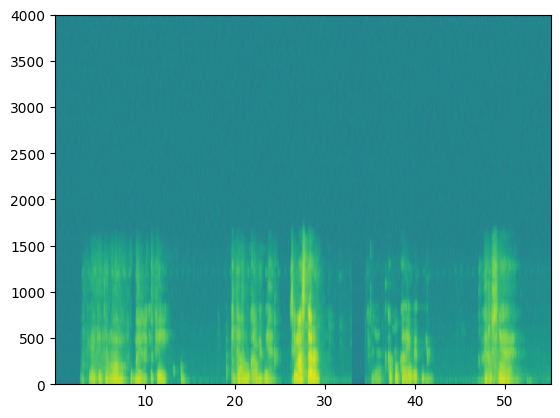

In [6]:
x = graph_spectrogram("./audio_examples/recorded_audio.wav")

Grafik di atas menggambarkan seberapa aktif setiap frekuensi (sumbu-y) terhadap langkah waktu (sumbu-x). Tapi apa arti sesungguhnya?

Warna-warna pada spektogram mewakili seberapa keras frekuensi yang berbeda pada berbagai titik waktu dalam audio. Warna hijau menunjukkan bahwa frekuensi tertentu lebih aktif dibanding frekuensi yang lain. Kemudian, warna biru menunjukkan bahwa frekuensi tersebut tidak begitu aktif. 

Muncul sebuah pertanyaan, dimensi dari spektogram ini bergantung pada apa? Dimensi spektogram bergantung pada _hyperparameter_ yang dipakai oleh _software_ yang membuat spektogram dan panjang dari masukkannya.

Proyek ini akan menggukanan audio berdurasi 10 detik sebagai standar untuk melatih model kita. Selain itu, proyek ini sudah diatur untuk menghasilkan 5511 langkah waktu pada spektogram dengan masukkan 10 detik. Inilah yang akan kita jadikan masukkan pada model kita $T_x = 5511$.

Mari kita coba pada contoh audio kita.

In [7]:
_, data = wavfile.read("./audio_examples/recorded_audio.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)


Tampak bahwa memang benar langkah waktu yang didapatkan adalah $T_x=5511$ dengan banyak frekuensi `n_freq`$=101$ sehingga kita bisa definisikan variabel-variabel berikut ini.

In [8]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

Perlu diketahui bahwa kita bisa saja membagi 10 detik audio dengan langkah waktu yang berbeda. Pada data mentah, kita membagi menjadi 441,000 langkah, sedangkan di spektogram kita membagi menjadi 5511 langkah. Untuk keperluan model, keluaran dari model akan membagi menjadi 1375 langkah $T_y=1375$. Semua angka-angka tersebut dapat diubah (kecuali 441,000 karena itu dari mikrofon).

Kita bisa definisikan variabel berikutnya.

In [9]:
Ty = 1375 # The number of time steps in the output of our model

### 2.4 Membuat Data Latih

Karena data suara sulit untuk diperoleh dan diberi label, kita akan membuat data latih secara sintetis dengan menggunakan klip-klip audio yang telah disiapkan, yaitu audio kata positif, kata negatif, dan suara latar. Proses untuk merekam langsung banyak klip audio berdurasi 10 detik yang di dalamnya sudah terdapat kata positif secara acak akan sangat lambat dan tidak efisien. Sebagai gantinya, akan jauh lebih mudah untuk merekam kata-kata positif dan negatif secara individual, lalu merekam suara latar secara terpisah (atau mengunduhnya) untuk kemudian digabungkan. Untuk melakukan sintesis data latih, kita akan mengambil secara acak suara latar. Kemudian, secara acak kita akan menempelkan 0-4 audiao kata positif dan 0-2 kata negatif ke dalam suara latar.

Pada proyek ini kita akan mengolah audio dengan bantuan pustaka `pydub`. Detail bagaimana prosesnya tak akan dijelaskan disini, tetapi perlu diketahu bahwa pustaka ini menggunakan interval 1ms untuk diskretisasinya. Itu berarti dalam 1 detik audio akan ada 1000 langkah dan 10 detik akan ada 10,000 langkah. Berikut pembuktiannya.

In [10]:
# Load audio segments using pydub 
simaster, negatives, backgrounds = load_raw_audio('./raw_data/')

print("background len should be 10,000, since it is a 10 sec clip\n" + str(len(backgrounds[0])),"\n")
print("simaster[0] len may be around 1000, since an `simaster` audio clip is usually around 1 second (but varies a lot) \n" + str(len(simaster[0])),"\n")
print("simaster[1] len: different `simaster` clips can have different lengths\n" + str(len(simaster[1])))

background len should be 10,000, since it is a 10 sec clip
10000 

simaster[0] len may be around 1000, since an `simaster` audio clip is usually around 1 second (but varies a lot) 
906 

simaster[1] len: different `simaster` clips can have different lengths
673


Sekarang kita tahu secara singkat bagaimana membuat data latih, tapi akan ada masalh kecil disini, yaitu _overlapping_. Masalah ini terjadi ketika kita menyisipkan sebuah klip kata baru pada rentang waktu yang tumpang tindih dengan klip kata yang sudah ada sebelumnya di dalam audio latar 10 detik tersebut. Untuk memastikan klip itu tidak tumpang tindih kita harus terus memeriksa interval waktu klip-klip yang sudah dimasukkan. Perlu diketahui, ketika kita menyisipkan klip sebuah kata ke 10 detik suara latar, durasinya akan tetap 10 detik dan tidak bertambah.

Sekarang katakanlah $y^{<t>}$ merepresentasikan apakah seseorang mengatakan kata "simaster" atau tidak. Dengan kata lain, $y^{<t>}=1$ ketika klip selesai mengatakan "simaster" dan $y^{<t>}=0$ ketika tak ada kata "simaster". Jadi, ketika kita menyisipkan klip positif ke suara latar (untuk latar $y^{<t>}=0$ untuk setiap $t$), kita harus memperbarui $y^{<t>}$. Namun, alih-alih hanya memperbarui di langkah $t$, kita akan memperbarui sampai 50 langkah kedepan $t+50$. Hal ini dilakukan agar mempermudah model untuk belajar dengan data yang lebih seimbang.

Untuk membantu mengimplementasikan langkah-langkah di atas, kita akan membuat beberapa fungsi sebagai berikut.
1. `get_random_time_segment(segment_ms)`
    - Mengembalikan sebuah segmen waktu acak dari suara latar.
2. `is_overlapping(segment_time, existing_segments)`
    - Melakukan pengecekan tumpang tindih.
3. `insert_audio_clip(background, audio_clip, existing_times)`
    - Menyisipkan sebuah klip audio ke segmen waktu yang sudah di tentukan ke suara latar.
    - Menggunakan fungsi `get_random_time_segment` dan `is_overlapping`
4. `insert_ones(y, segment_end_ms)`
    - Menambahkan nilai 1 ke vektor y setelah kata "simaster"

#### 2.4.1 Mendapatkan Segmen Acak

In [11]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

#### 2.4.2 Mengecek Tumpang Tindih

In [12]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """

    segment_start, segment_end = segment_time
    
    # Step 1: Initialize overlap as a "False" flag.
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap
    for previous_start, previous_end in previous_segments:
        if segment_start<=previous_end and segment_end>=previous_start:
            overlap = True
            break

    return overlap

#### 2.4.3 Menyisipkan Audio

In [13]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip.
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. To avoid an endless loop
    # we retry 5 times
    retry = 5 
    while is_overlapping(segment_time, previous_segments) and retry >= 0:
        segment_time = get_random_time_segment(segment_ms)
        retry = retry - 1
    # if last try is not overlaping, insert it to the background
    if not is_overlapping(segment_time, previous_segments):
        # Step 3: Append the new segment_time to the list of previous_segments
        previous_segments.append(segment_time)
        # Step 4: Superpose audio segment and background
        new_background = background.overlay(audio_clip, position = segment_time[0])
    else:
        new_background = background
        segment_time = (10000, 10000)
    
    return new_background, segment_time

#### 2.4.4 Update ke Nilai 1

In [14]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 following labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    _, Ty = y.shape
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    if segment_end_y < Ty:
        # Add 1 to the correct index in the background label (y)
        for i in range(segment_end_y+1, segment_end_y+51):
            if i < Ty:
                y[0, i] = 1
    
    return y

#### 2.4.5 Membuat Data Latih

In [15]:
def create_training_example(background, simaster, negatives, Ty):
    """
    Creates a training example with a given background, simaster, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    simaster -- a list of audio segments of the word "simaster"
    negatives -- a list of audio segments of random words that are not "simaster"
    Ty -- The number of time steps in the output

    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Make background quieter
    background = background - 20

    # Step 1: Initialize y (label vector) of zeros
    y = np.zeros((1,Ty))

    # Step 2: Initialize segment times as empty list
    previous_segments = []
    
    # Select 0-4 random "simaster" audio clips from the entire list of "simaster" recordings
    number_of_simaster = np.random.randint(0, 5)
    random_indices = np.random.randint(len(simaster), size=number_of_simaster)
    random_simaster = [simaster[i] for i in random_indices]
    
    # Step 3: Loop over randomly selected "simaster" clips and insert in background
    for one_random_simaster in random_simaster:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, one_random_simaster, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y" at segment_end
        y = insert_ones(y, segment_end)

    # Select 0-4 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 5)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y

Kita sudah mengimplementasikan semua fungsi-fungsi yang kita perlukan. Selanjutnya kita hanya perlu mensitesis data latih sebanyak yang kita inginkan. Ingat, jika ingin mensintesis data yang besar pastikan komputermu memadai!

0
10
20
30


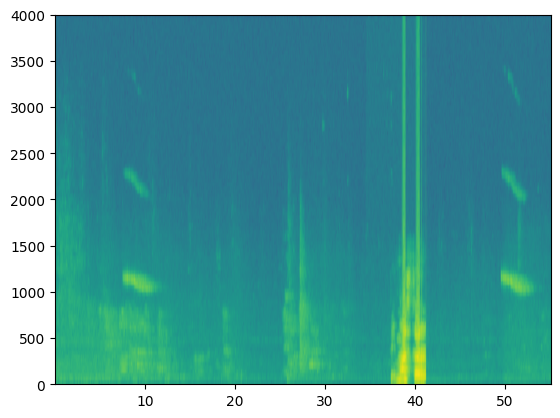

In [16]:
np.random.seed(4543) # Set seed for reproducibility
nsamples = 32 # Number of training examples to create
X = []
Y = []
for i in range(0, nsamples):
    if i%10 == 0:
        print(i)
    x, y = create_training_example(backgrounds[i % 2], simaster, negatives, Ty)
    X.append(x.swapaxes(0,1))
    Y.append(y.swapaxes(0,1))
X = np.array(X)
Y = np.array(Y)

In [17]:
# # Uncomment the following lines to save the data

# # Save the data for further uses
# np.save(f'./processed_data/data_train/X.npy', X)
# np.save(f'./processed_data/data_train/Y.npy', Y)

# # Load the preprocessed training examples
# X = np.load("./processed_data/data_train/X.npy")
# Y = np.load("./processed_data/data_train/Y.npy")

## 3. Pembangunan Model

### 3.1 Komponen dan Pustaka

Pada bagian ini akan digunakan pustaka `tensorflow` yang terkenal luas sebagai pustaka canggih untuk mendesain dan membangun sebuah model _deep learning_.

In [20]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, TimeDistributed, Conv1D
from tensorflow.keras.layers import GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam

### 3.2 Model

Tujuan kita disini adalah membangun sebuah model yang menerima masukan berupa data spektogram dan mengeluarkan sinyal ketika mendeteksi kata positif. Pada proyek ini, kita akan menggunakan model dengan 4 lapisan utama, yaitu sebuah lapisan konvolusi, 2 lapisan _Gated Recurren Unit_ (GRU), dan sebuah lapisan _dense_. Berikut detail arsitektur yang akan digunakan

<center><img src="images/arsitektur.png" style="width:800px;"></center>
<center><em>Gambar 1. Arsitektur Model</em></center>

Pada bagian bawah _Gambar 1._, terdapat sebuah lapisan konvolusi 1-dimensi dengan ukuran masukkan 5511 langkah waktu dari spektogram (setiap langkah berisi vektor dengan 101 elemen). Lapisan ini akan memberikan keluaran dengan ukuran 1375 langkah waktu yang akan diproses lebih lanjut oleh lapisan-lapisan di atasnya.

Sedikit ke atas, terdapat dua lapisan GRU untuk mengolah data sekuensial hasil keluaran lapisan sebelumnya. GRU akan mengolah data sekuensial mulai dari langkah waktu ke-0 sampai langkah waktu ke-$T_y$ (dari kiri ke kanan). Perlu diketahui bahwa arsitektur ini menggunakan _unidirectional_ GRU alih-alih _bidirectional_. Hal ini karena dalam tugas ini, berfokus pada konteks (baca: kata) di masa lalu lebih penting dibandingkan konteks di masa depan. 

Pada bagian teratas, dapat kita jumpai sebuah lapisan _dense_ dengan fungsi aktivasi sigmoid. Lapisan ini yang akan membuat prediksi untuk $y^{<t>}$ (nilai keluaran pada saat langkah waktu ke-$t$). Hal ini dilakukan dengan mempertimbangkan fakta bahwa nilai $y$ adalah _binary_ (0 atau 1) sehingga kita gunakan sigmoid di akhir untuk mengestimasi kemungkinan keluarannya bernilai 1.

#### 3.2.1 Implementasi Arsitekur

In [21]:
def modelf(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV layer
    # Add a Conv1D with 196 units, kernel size of 15 and stride of 4
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)
    # Batch normalization
    X = BatchNormalization()(X)
    # ReLu activation
    X =  Activation("relu")(X)
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X)                                  

    # Step 2: First GRU Layer
    # GRU (use 128 units and return the sequences)
    X = GRU(units=128, return_sequences =True)(X)
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X) 
    # Batch normalization.
    X = BatchNormalization()(X)                           
    
    # Step 3: Second GRU Layer
    # GRU (use 128 units and return the sequences)
    X = GRU(units=128, return_sequences =True)(X)
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X) 
    # Batch normalization.
    X = BatchNormalization()(X) 
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X)                                 
    
    # Step 4: Time-distributed dense layer
    # TimeDistributed  with sigmoid activation 
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) 

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [22]:
model = modelf(input_shape = (Tx, n_freq))

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5511, 101)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1375, 196)      │       297,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1375, 196)      │           784 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1375, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1375, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 1375, 128)      │       125,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1375, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1375, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 1375, 128)      │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1375, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1375, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1375, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1375, 1)        │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,329 (2.00 MB)

 Trainable params: 522,425 (1.99 MB)

 Non-trainable params: 904 (3.53 KB)

#### 3.2.2 Melatih Model

Melatih model akan sangat memakan waktu dan membutuhkan sumber daya yang besar. Oleh karenanya, disini kita akan menggunakan model yang telah dilatih sebelumnya untuk tugas yang sama dengan kasus berbeda. Dengan begitu, proses latih akan lebih cepat dan efisien.

In [22]:
# Load only the weights
model.load_weights('./models/model.h5')

print("Model recreated and weights loaded successfully")

Model recreated and weights loaded successfully


Untuk memastikan agar hanya melakukan pembaruan pada model, kita perlu membekukan beberapa lapisan _batch normalization_ arsitektur kita. Namun, jika kita akan melatih model dari nol, maka tak perlu membekukan lapisan-lapisan dibawah ini.

In [23]:
model.layers[2].trainable = False
model.layers[7].trainable = False
model.layers[10].trainable = False

Selanjutnya, kita akan definisikan beberapa _hyperparameter_ optimisasi yang digunakan, yaitu `learning_rate`, dan `beta`. Selain itu, kita juga akan memberitahu model bahwa metode untuk melakukan perhitungan _loss_ adalah `binary_crossentropy` (umum digunakan untuk klasifikasi biner).

In [24]:
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [ ]:
# Train the model
model.fit(X, Y, batch_size = 16, epochs= 25)

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 63s 10s/step - accuracy: 0.9143 - loss: 0.2568
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step - accuracy: 0.9112 - loss: 0.2296
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 11s/step - accuracy: 0.9164 - loss: 0.2199
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 12s/step - accuracy: 0.9150 - loss: 0.2258
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 10s/step - accuracy: 0.9133 - loss: 0.2299
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step - accuracy: 0.9191 - loss: 0.2201
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 8s/step - accuracy: 0.9194 - loss: 0.2114
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 9s/step - accuracy: 0.9236 - loss: 0.2073
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step - accuracy: 0.9252 - loss: 0.2008
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step - accuracy: 0.9280 - loss: 0.1927
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 11s/step - accuracy: 0.9281 - loss: 0.1910
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 8s/step - accuracy: 0.9264 - loss: 0.1904
Epoch 

In [ ]:
# save the model as keras file
model.save('./models/model_new.h5')

# make sure the loaded model is the same as the saved one
model = load_model('./models/model_new.h5')

#### 3.2.3 Validasi Model

Untuk memastikan model berhasil melakukan generalisasi, diperlukan pengujian terhadap data yang sebelumnya tak pernah dilihat oleh model. Disini kita akan mengimport data yang telah disiapkan dan langsung mengujinya pada model yang telah kita latih sebelumnya. Perlu diperhatikan bahwa apabila selisih antara hasil validasi dan hasil latih cukup besar, maka ada kemungkinan terjadi _overfitting_ dan itu adalah sebuah masalah yang harus diatasi.

In [25]:
# Load the preprocessed training examples
X_dev = np.load("./processed_data/data_val/X_dev.npy")
Y_dev = np.load("./processed_data/data_val/Y_dev.npy")

In [26]:
loss, acc = model.evaluate(X_dev, Y_dev, batch_size=16)
print("Dev set loss:", loss)
print("Dev set accuracy:", acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step - accuracy: 0.9265 - loss: 0.1711
Dev set loss: 0.17088483273983002
Dev set accuracy: 0.9248872995376587


## 4. Pendeteksian Suara

### 4.1 Komponen dan Pustaka

Pada bagian ini kita akan menggunakan beberapa komponen dan pustaka python untuk membantu pemrosesan audio. Berikut pustaka-pustaka yang akan digunakan.

1. **`sys`**: Digunakan untuk berinteraksi dengan sistem, seperti menulis ke _standard output_ untuk memberikan umpan balik visual saat mikrofon mendeteksi suara atau keheningan.
2. **`webbrowser`**: Berfungsi untuk melakukan aksi setelah _trigger word_ terdeteksi, yaitu membuka sebuah halaman web pada _browser_ default.
3. **`pydub`**: Digunakan untuk memuat dan memutar file audio, seperti suara notifikasi (`chime.wav`) ketika _trigger word_ berhasil terdeteksi.
4. **`pyaudio`**: Pustaka inti untuk mengakses _stream_ audio secara _real-time_ dari mikrofon. Pustaka ini memungkinkan program untuk "mendengarkan" lingkungan sekitar.
5. **`time`**: Digunakan untuk mengelola waktu, misalnya untuk mengatur durasi total program berjalan (_timeout_).
6. **`queue`**: Digunakan untuk membuat antrian yang aman untuk komunikasi antara _thread_ audio (yang menangkap suara) dan _thread_ utama (yang memproses suara), memastikan tidak ada data yang hilang atau rusak.

In [1]:
import sys
import webbrowser
import numpy as np
from pydub import AudioSegment
from pydub.playback import play
import pyaudio
from td_utils import *
import time
import queue
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

### 4.2 Handling Audio

Karena kita akan mengambil input _real time_, maka perlu ada proses khusus dalam menangani masukan suara kita. Dalam hal ini, pendeteksian suara bekerja secara berurutan dalam sebuah alur proses. Pertama, sistem secara kontinu mendapatkan sinyal audio dari mikrofon dalam bentuk potongan-potongan data pendek (_chunk_) berdurasi 0.5 detik. Potongan-potongan ini kemudian dikumpulkan dalam sebuah _buffer_ hingga data yang terkumpul cukup untuk membentuk satu blok masukan lengkap (_feed_) berdurasi 10 detik. Setelah _feed_ ini siap, seluruh blok data audio (terdiri dari 441,000 langkah waktu) dikirimkan sebagai satu masukan tunggal ke model kita yang telah dilatih.

In [2]:
chunk_duration = 0.5  # Each read length in seconds from mic.
fs = 44100  # sampling rate for mic
chunk_samples = int(fs * chunk_duration)  # Each read length in number of samples.

# Each model input data duration in seconds, need to be an integer numbers of chunk_duration
feed_duration = 10
feed_samples = int(fs * feed_duration)

# Check if feed_duration is an integer multiple of chunk_duration
assert feed_duration / chunk_duration == int(feed_duration / chunk_duration)

# load the model
model = load_model('./models/model_new.h5')

Untuk memulai, kita akan mendefinisikan fungsi yang akan kita gunakan untuk mendeteksi _trigger word_ dengan model yang sudah kita siapkan. Berikut implementasinya.

In [3]:
def detect_triggerword_spectrum(x):
    """
    Function to predict the location of the trigger word.

    Argument:
    x -- spectrum of shape (freqs, Tx)
    i.e. (Number of frequencies, The number time steps)

    Returns:
    predictions -- flattened numpy array to shape (number of output time steps)
    """
    # the spectogram outputs  and we want (Tx, freqs) to input into the model
    x = x.swapaxes(0, 1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    return predictions.reshape(-1)

Fungsi di atas telah berhasil memberikan kita prediksi mentah dari model. Namun, prediksi ini masih berupa serangkaian probabilitas untuk seluruh durasi audio input. Ini belum cukup untuk membuat sistem yang responsif dan akurat. Kita perlu mekanisme tambahan untuk menerjemahkan prediksi mentah ini menjadi sebuah keputusan akhir yang cerdas dan hanya aktif satu kali saat _trigger word_ baru saja diucapkan. Untuk itu, kita akan mengimplementasikan fungsi `has_new_triggerword`. Fungsi ini akan fokus hanya pada bagian terakhir dari data prediksi (yang sesuai dengan _chunk_ audio terbaru) dan menggunakan logika _rising edge detection_ untuk memastikan pemicu hanya aktif satu kali pada saat yang tepat, bukan berulang-ulang.

In [4]:
def has_new_triggerword(predictions, chunk_duration, feed_duration, threshold=0.8):
    """
    Function to detect new trigger word in the latest chunk of input audio.
    It is looking for the rising edge of the predictions data belongs to the
    last/latest chunk.

    Argument:
    predictions -- predicted labels from model
    chunk_duration -- time in second of a chunk
    feed_duration -- time in second of the input to model
    threshold -- threshold for probability above a certain to be considered positive

    Returns:
    True if new trigger word detected in the latest chunk
    """
    predictions = predictions > threshold
    chunk_predictions_samples = int(len(predictions) * chunk_duration / feed_duration)
    chunk_predictions = predictions[-chunk_predictions_samples:]
    level = chunk_predictions[0]
    for pred in chunk_predictions:
        if pred > level:
            return True
        else:
            level = pred
    return False

Karena kita akan mengambil masukan langsung secara _real time_ kita perlu mendefiniskan fungsi yang dapat mengambil langsung dan menyimpan audio dari mikrofon. Disini kita memanfaatkan pustaka `pyaudio` untuk menangani audio. Perlu diketahui bahwa disini kita juga menggunakan _callback function_ yang akan dipanggil setiap satu audio diterima (akan dijelaskan nanti). Berikut implementasi fungsinya.

In [5]:
def get_audio_input_stream(callback):
    """
    Function to get audio input stream from the microphone.

    Argument:
    callback -- function to call with the audio data

    Returns:
    stream -- pyaudio stream object
    """

    stream = pyaudio.PyAudio().open(
        format=pyaudio.paInt16,
        channels=1,
        rate=fs,
        input=True,
        frames_per_buffer=chunk_samples,
        stream_callback=callback,
    )
    return stream

Jika masih ingat, model kita didesain untuk menerima inputan berupa data spektogram. Untuk itu, kita perlu memproses data audio menjadi data spektogram terlebih dahulu sebelum dimasukkan ke dalam model untuk diprosess. Berikut implementasinya.

In [6]:
def get_spectrogram(data):
    """
    Function to compute a spectrogram.

    Argument:
    predictions -- one channel / dual channel audio data as numpy array

    Returns:
    pxx -- spectrogram, 2-D array, columns are the periodograms of successive segments.
    """
    nfft = 200  # Length of each window segment
    fs = 8000  # Sampling frequencies
    noverlap = 120  # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, _, _, _ = plt.specgram(data, nfft, fs, noverlap=noverlap)
    elif nchannels == 2:
        pxx, _, _, _ = plt.specgram(data[:, 0], nfft, fs, noverlap=noverlap)
    return pxx

Selanjutnya kita akan mendefinisikan fungsi _callback_ yang akan digunakan selama pemrosesan audio. Fungsi ini bekerja bersama sebuah _queue_ (antrean) dan _buffer_ data. Setiap kali potongan audio baru diterima dari mikrofon, _callback_ akan menyaring suara hening, kemudian memperbarui sebuah _buffer_ utama agar selalu berisi 10 detik audio terakhir melalui mekanisme _sliding window_. Setelah _buffer_ diperbarui, salinan lengkapnya segera dimasukkan ke dalam _queue_ (`q.put(data)`).

In [9]:
# Queue to communiate between the audio callback and main thread
q = queue.Queue()
run = True
silence_threshold = 100
# Run the demo for a timeout seconds
timeout = time.time() + 5 * 60  # 0.5 minutes from now
# Data buffer for the input wavform
data = np.zeros(feed_samples, dtype="int16")


def callback(in_data, frame_count, time_info, status):
    """
    Callback function to process audio input data from the microphone. 
    It checks if the audio data is silent, and if not, it appends the data to a buffer.
    If the data is not silent, it sends the data to a queue for further processing.
    If the timeout is reached, it stops the audio stream.

    Arguments:
    in_data -- audio data from the microphone

    Returns:
    (in_data, pyaudio.paContinue) -- tuple to continue the audio stream
    """
    global run, timeout, data, silence_threshold
    if time.time() > timeout:
        run = False
    # Convert raw audio data to AudioSegment
    data0 = np.frombuffer(in_data, dtype="int16")

    if np.abs(data0).mean() < silence_threshold:
        sys.stdout.write("*")
        return (in_data, pyaudio.paContinue)
    else:
        sys.stdout.write("n")
    data = np.append(data, data0)
    if len(data) > feed_samples:
        data = data[-feed_samples:]
        # Process data async by sending a queue.
        q.put(data)
    return (in_data, pyaudio.paContinue)

### 4.3 Menyusun Semuanya

Disini kita akan menyusun seluruh fungsi yang telah kita buat menjadi alur program yang utuh. Untuk setiap _trigger word_ yang terdeteksi kita akan membuka situs SIMASTER milik UGM.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


C:\Users\haida\AppData\Local\Temp\ipykernel_16380\3300520979.py:16: MatplotlibDeprecationWarning: Passing the NFFT parameter of specgram() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  pxx, _, _, _ = plt.specgram(data, nfft, fs, noverlap=noverlap)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
**Website dibuka!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
************************************n

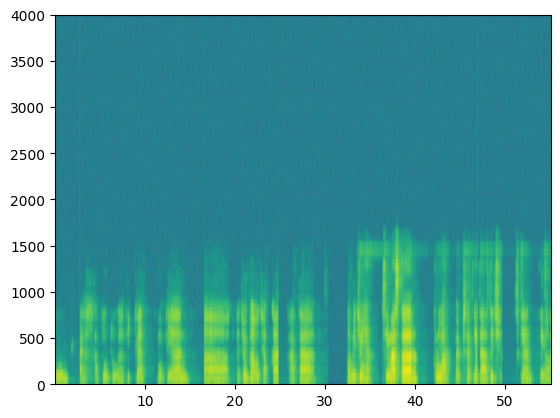

In [10]:
stream = get_audio_input_stream(callback)
stream.start_stream()

try:
    while run:
        data = q.get()
        spectrum = get_spectrogram(data)
        preds = detect_triggerword_spectrum(spectrum)
        new_trigger = has_new_triggerword(
            preds, chunk_duration, feed_duration, threshold=0.5
        )
        if new_trigger:
            # play the sound
            sound = AudioSegment.from_wav("./audio_examples/chime.wav")
            play(sound)
            webbrowser.open("https://simaster.ugm.ac.id/")
            print("Website dibuka!")
except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time.time()
    run = False

stream.stop_stream()
stream.close()

## 5. Refrensi

- [Deep Learning Specilization Course by Andrew Ng](https://github.com/amanchadha/coursera-deep-learning-specialization)
- [How to do Real Time Trigger Word Detection with Keras](https://www.dlology.com/blog/how-to-do-real-time-trigger-word-detection-with-keras/)

# Thank You! ^^

Terima kasih telah membaca hingga akhir. Semoga proyek ini bisa menginspirasi dan membantu!

---